In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math

In [34]:
# Set up files
dir_noQuestion = 'data/letterSixBlocksData/first_second_Runs_sixBlocks'
files_noQuestion = [f for f in os.listdir(dir_noQuestion) if f.endswith('.csv')]

dir_effortQ = 'data/letterSixBlocksData/thirdRun_effortQ'
files_effortQ = [f for f in os.listdir(dir_effortQ) if f.endswith('.csv')]


numTotalSubj = len(files_noQuestion) + len(files_effortQ)

print('Number of subjects: ', numTotalSubj)


Number of subjects:  19


In [35]:
def getThresholds(mydir, files, block_end, question_blocks_bool, numRepeats = 6, block_start = 2, 
                     num_staircase_per_block = 2, num_trials_per_staircase = 35):
    
    # initialize data matrix
    numSubj = len(files)
    
    if num_staircase_per_block == 2:
        subj_left = np.full((numSubj, numRepeats), np.nan)
        subj_right = np.full((numSubj, numRepeats), np.nan)

    
    # calculate thresholds
    for subj in range(numSubj):

        # Read the CSV file
        file_path = os.path.join(mydir, files[subj])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            print(f'Warning: incomplete experiment (Subject {subj+1}, Block {b-1}, staircase {s})')

        if question_blocks_bool:
            blocks_include = range(block_start, block_end, 2)
        else:
            blocks_include = range(block_start, block_end + 1)
            
        for b in blocks_include:  # Loop over blocks
                
            for s in range(num_staircase_per_block):  # Loop over staircases

                blockOfInterest = b
                staircase = s + 1
                staircase_name = f'{blockOfInterest}_{staircase}'
                # Filter rows based on block and staircase
                rows_staircase = mainOutput[mainOutput['staircaseName'] == staircase_name]

                # Exclusion criteria 2: number of trials sent to quest
                # Count trials sent to quest
                trial_sent = rows_staircase['trialGivenToQuest']
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                if not trial_sent_bool:
                    print(f'Warning: not enough trials (Subject {subj+1}, Block {b}, staircase {s}, {trial_sent_bool} trials)')


                # Exclusion criteria 3: questSD > 0.1
                questSD = rows_staircase['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                if not small_questSD_bool:
                    print(f'Warning: large SD (Subject {subj+1}, Block {b}, staircase {s})')


                # Process thresholds
                if complete_bool and trial_sent_bool and small_questSD_bool:
                    thresholds_raw = rows_staircase['questMeanAtEndOfTrialsLoop'].dropna().values
                    assert len(thresholds_raw) == 1, 'Error: more than 1 thresholds'

                    thresholds_raw_log = thresholds_raw[0]

                    thresholds_raw_deg = 10 ** thresholds_raw_log

                    # Assign to left and right array
                    if s == 0:
                        if question_blocks_bool:
                            subj_right[subj, b//2 - 1] = thresholds_raw_deg

                        else:
                            subj_right[subj, b - 2] = thresholds_raw_deg

                            
                    elif s == 1: 
                        if question_blocks_bool:
                            subj_left[subj, b//2 - 1] = thresholds_raw_deg

                        else:
                            subj_left[subj, b - 2] = thresholds_raw_deg
                    else:
                        print('Warning: invalide staircase number.')
                else:
                    if s == 0:
                        if question_blocks_bool:
                            subj_right[subj, b//2 - 1] = np.nan

                        else:
                            subj_right[subj, b - 2] = np.nan

                            
                    elif s == 1: 
                        if question_blocks_bool:
                            subj_left[subj, b//2 - 1] = np.nan

                        else:
                            subj_left[subj, b - 2] = np.nan
                    else:
                        print('Warning: invalide staircase number.')
                    
                        
                        
    return subj_right, subj_left
                        



In [36]:
block_end = 7
subj_right_noQ, subj_left_noQ = getThresholds(dir_noQuestion, files_noQuestion, 7, False)

In [37]:
block_start = 2
numRepeats = 6
block_end = block_start + 2 * numRepeats - 1 
subj_right_effortQ, subj_left_effortQ = getThresholds(dir_effortQ, files_effortQ, block_end, True)

In [39]:
subj_right_thresholds = np.vstack((subj_right_noQ, subj_right_effortQ))
subj_left_thresholds = np.vstack((subj_left_noQ, subj_left_effortQ))

print('Right thresholds shape:', subj_right_thresholds.shape)
print('Left thresholds shape:', subj_left_thresholds.shape)

Right thresholds shape: (19, 6)
Left thresholds shape: (19, 6)


## Plot summary of Bouma factors

In [69]:
def plot_RL_thresholds(subj_left, subj_right, repeats = range(1, 7),
                             patch_min = 0.18, patch_max = 0.41):

    plt.figure(figsize=(10, 6))
    # plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
    for i, row in enumerate(subj_right):
        plt.plot(repeats, row, marker='o', label=f'Participant {i+1}')
    plt.title('Right Thresholds')
    plt.xlabel('Repeats')
    plt.ylabel('Letter acuity thresholds')
    plt.legend()
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim([0.08,1.2])
    tick_positions = np.linspace(0.1, 1, num=4)  
    plt.yticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions], fontsize = 12)

    plt.show()

    plt.figure(figsize=(10, 6))
    # plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
    for i, row in enumerate(subj_left):
        plt.plot(repeats, row, marker='o', label=f'Participant {i+1}')
    plt.title('Left Thresholds')
    plt.xlabel('Repeats')
    plt.ylabel('Letter acuity thresholds')
    plt.legend()
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim([0.08,1.2])
    tick_positions = np.linspace(0.1, 1, num=4)  
    plt.yticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions], fontsize = 12)

    
    plt.show()


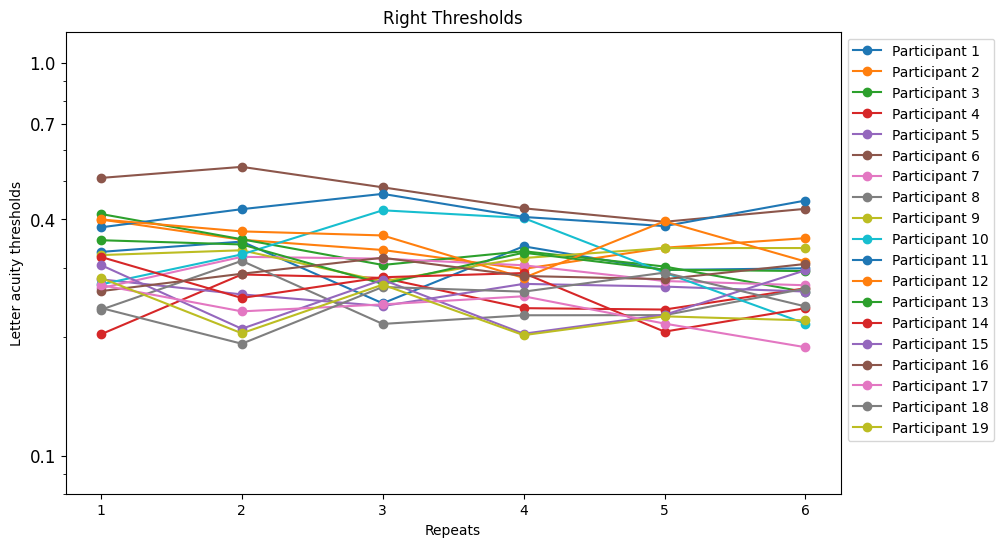

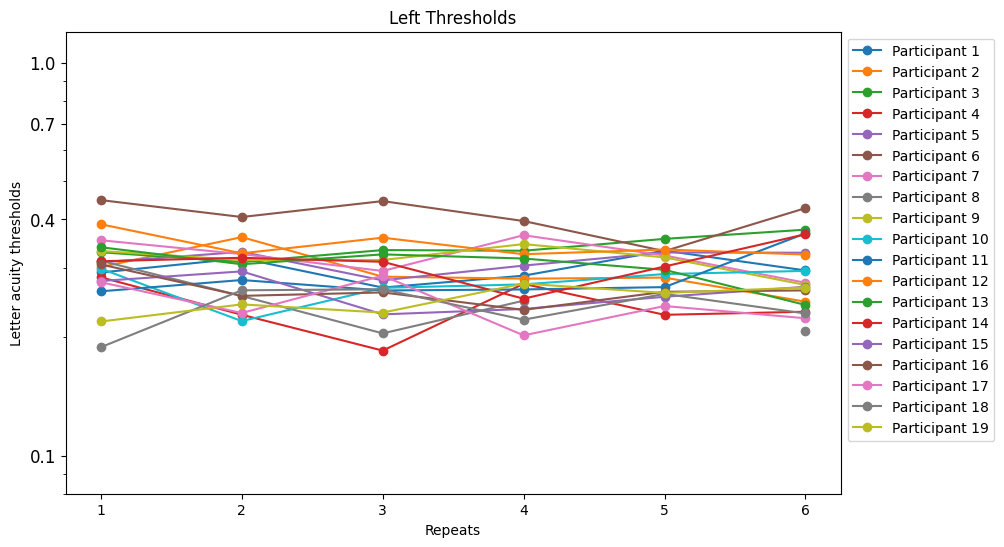

In [70]:
plot_RL_thresholds(subj_left_thresholds, subj_right_thresholds)

# plot_RL_thresholds(subj_left_effortQ/eccentricity, subj_right_effortQ/eccentricity)

## Left-right asymmetry

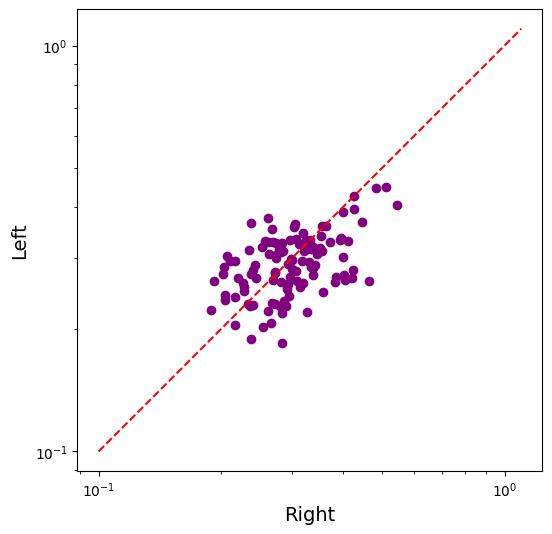

In [71]:
    # Create scatter plot
    plt.figure(figsize=(6, 6))  # Make the plot square
    plt.scatter(subj_right_thresholds, subj_left_thresholds, color='purple')
    plt.plot([0.1, 1.1], [0.1, 1.1], color='red', linestyle='--', label='y = x')  # Line y = x

    # Set axes to have equal scale
    plt.axis('equal')
    plt.xscale('log')
    plt.yscale('log')
    # Add labels and legend
    plt.xlabel(f'Right', fontsize = 14)
    plt.ylabel(f'Left', fontsize = 14)

    # Show the plot
    plt.show()

## Average between left and right; take the log
- If we are correlating crowding with other factors like acuity and reading, we will probably average left and right before the analysis.
- Before analyzing data, always take the log.

In [72]:
# exclude participant 2 due to unreliable performance
# filtered_left_bouma = np.delete(subj_left_bouma, 1, axis=0)
# filtered_left_bouma = subj_left

subj_avgRL_log = (np.log10(subj_right_thresholds) + np.log10(subj_left_thresholds)) / 2

print(subj_avgRL_log)

[[-0.50749634 -0.47628653 -0.59214354 -0.50445474 -0.50272887 -0.52579492]
 [-0.45931119 -0.44703572 -0.51040566 -0.536997   -0.50871007 -0.52721035]
 [-0.43345605 -0.47814475 -0.49560684 -0.4789997  -0.4833681  -0.50407138]
 [-0.61854092 -0.59003188 -0.64003146 -0.59357569 -0.6347934  -0.60374426]
 [-0.52956121 -0.53534878 -0.58638442 -0.53948259 -0.52618575 -0.53282387]
 [-0.32123218 -0.32867791 -0.33445195 -0.38652684 -0.44200216 -0.37079663]
 [-0.51263368 -0.49042478 -0.51420346 -0.47713138 -0.52290633 -0.56304474]
 [-0.56625274 -0.5488598  -0.67667789 -0.62407925         nan -0.62859627]
 [-0.48422801 -0.4896411  -0.5291352  -0.47913414 -0.48338545 -0.51848526]
 [-0.5441098  -0.57253041 -0.47408884 -0.47954502 -0.53586743 -0.59669192]
 [-0.50019753 -0.46272358 -0.45656678 -0.48462374 -0.49329597 -0.39242757]
 [-0.40487725 -0.45702974 -0.44228072 -0.51738593 -0.43930466 -0.49691228]
 [-0.46056549 -0.48754148 -0.52514255 -0.49076655 -0.52675483 -0.57323114]
 [-0.49962065 -0.54744772

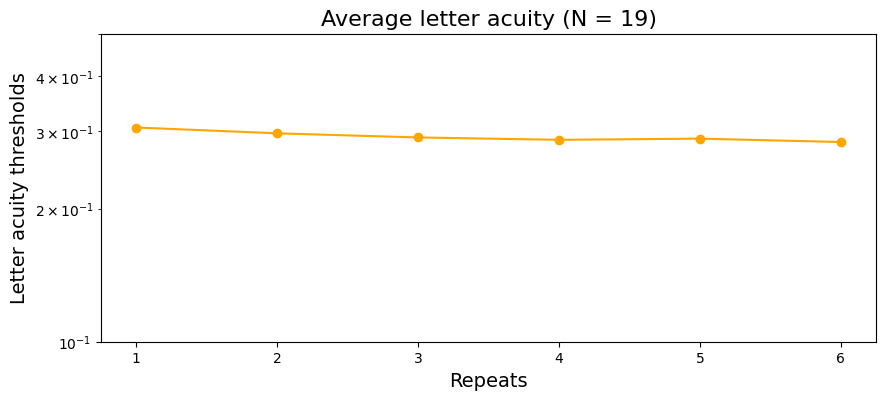

In [74]:
plt.figure(figsize=(10, 4))

plt.plot(range(1,7), 10 ** np.nanmean(subj_avgRL_log, axis = 0), marker='o', color = 'orange')
plt.title(f'Average letter acuity (N = {numTotalSubj})', fontsize = 16)
plt.xlabel('Repeats', fontsize = 14)
plt.xticks(range(1,7))
plt.ylabel('Letter acuity thresholds', fontsize = 14)
plt.yscale('log')
plt.ylim([0.1, 0.5])
# plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.gca().tick_params(labelsize=14)
plt.show()

In [75]:
print(np.nanmean(subj_avgRL_log, axis = 0))

[-0.51386768 -0.52706713 -0.53642291 -0.54179917 -0.53912145 -0.54680033]


## Within- and between-subject standard deviations

Take the variance of the log thresholds, and then square-root to get the standard deviation.

In [76]:
def calculate_within_btw_std(subj_thresholds):
    '''
    Input: subj_thresholds is organized as follows: rows are subjects and columns are repeats
    It is assumed that subj_thresholds contain LOG THRESHOLDS!
    '''

    within_individual_std = np.nanmean(np.nanvar(subj_thresholds, axis=1, ddof=1))


    across_individuals_std = np.nanvar(np.nanmean(subj_thresholds, axis=1), ddof=1)

    # 3. Total Variance: Variance across all participants and all runs
    #total_std = np.std(subj_thresholds, ddof=1)

    return within_individual_std, across_individuals_std

def calculate_btw_within_ratio(btw, within):
    '''
    Input: btw and within individual std IN LOG UNITS
    '''
    assert(btw.shape == within.shape)
    
    ratio = (10**btw)/(10**within)
    
    return ratio

## "Stable" estimates of each threshold

# Q: Within-individual variance is stable if we use thresholds in linear units, but not if we use thresholds in log units?

In [77]:
def variance_summary_forward(threshold_mtx, start_block = 3):
    
    numRepeats = threshold_mtx.shape[1]
    numVar = numRepeats - start_block + 1

    
    within_forward = np.full((numVar,1),np.nan)
    btw_forward = np.full((numVar,1),np.nan)
    
    
    for ii in range(start_block,numRepeats+1):

        filtered_data = threshold_mtx[:,:ii]
        
        within_forward[ii-start], btw_forward[ii-start] = calculate_within_btw_std(filtered_data)
    
    # plot
    repeats = range(start_block, numRepeats+1)
    
    plt.figure(figsize=(10, 4))
    plt.plot(repeats, within_forward, marker='o', label='within-individual variance')
    plt.plot(repeats, btw_forward, marker='o', label='between-individual variance')

    plt.title('within- and between- individual std: including from first repeat', fontsize = 16)
    plt.xlabel('Repeats including until', fontsize = 14)
    plt.xticks(repeats)
#     plt.ylim([0.01, 0.04])
    plt.ylabel('Variance of log Bouma factors', fontsize = 14)
    plt.legend()
    plt.yscale('log')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.gca().tick_params(labelsize=14)
    plt.show()

Note:

Btw: 
- including more repeats (data points) -> averaging: will be closer to the true
- therefore, between-variance might decrease noise and decrease var

Instead compute one variance across people for each block. and see how that changes (if there's learning it will decrease over the 6 blocks. if not it will stay flat and a bit noisy)



In [78]:
def variance_summary_backwards(threshold_mtx):
    
    numRepeats = threshold_mtx.shape[1]
    
    within_forward = np.full((numRepeats-2,1),np.nan)
    btw_forward = np.full((numRepeats-2,1),np.nan)

    
    for ii in range(numRepeats-2):

        filtered_data = threshold_mtx[:,ii:]
        
        within_forward[ii], btw_forward[ii] = calculate_within_btw_std(filtered_data)
    
    # plot
    repeats = range(1,numRepeats - 1)
    
    plt.figure(figsize=(10, 4))
    plt.plot(repeats, within_forward, marker='o', label='within-individual variance')
    plt.plot(repeats, btw_forward, marker='o', label='between-individual variance')

    plt.title('within- and between- individual std: including till the last repeat', fontsize = 16)
    plt.xlabel('Repeats including from', fontsize = 14)
    plt.xticks(repeats)
#     plt.ylim([0.01, 0.04])
    plt.ylabel('Variance of log Bouma factors', fontsize = 14)
    plt.legend()
    plt.yscale('log')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.gca().tick_params(labelsize=14)
    plt.show()

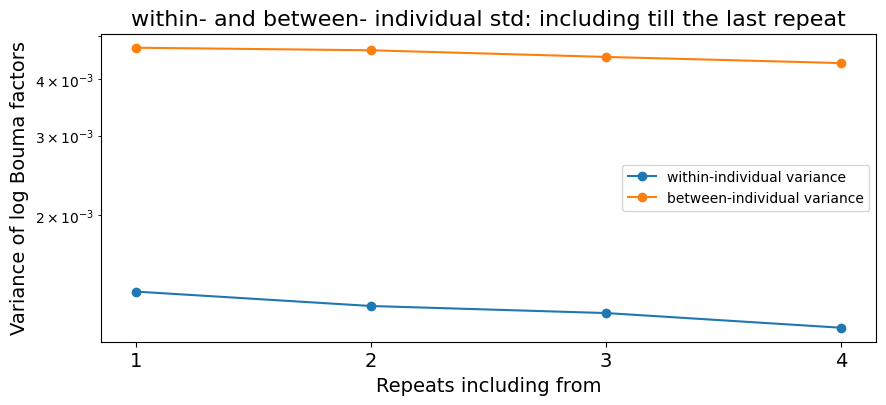

In [79]:
variance_summary_backwards(subj_avgRL_log)


## Average pairs of thresholds

In [80]:
def average_repeats(threshold_mtx, repeat_to_avg):
    '''
    Threshold_mtx contains log thresholds. Rows are subjects. Columns are repeats.
    Repeat_to_avg contains an array of lists. Each list specifies which repeats to average.
    1 should be subtracted from each list in repeat_to_avg before indexing threshold_mtx 
    '''
    
    numDP = len(repeat_to_avg)
    numSubj = threshold_mtx.shape[0]
    
    subj_summarized_log = np.full((numSubj, numDP),np.nan)
    
    for ii in range(numDP):
        
        subj_summarized_log[:,ii] = np.nanmean(threshold_mtx[:,np.array(repeat_to_avg[ii])-1], axis = 1)
    
    return subj_summarized_log

In [81]:
subj_testRetest_log = average_repeats(subj_avgRL_log, [[1,3],[2,4]])
within_4rep_testRetest, btw_4rep_testRetest = calculate_within_btw_std(subj_testRetest_log)
print(f'4 repeats, test-retest \n Within: {within_4rep_testRetest}\n Between: {btw_4rep_testRetest}')

subj_testRetest_log = average_repeats(subj_avgRL_log, [[1,3,5],[2,4,6]])
within_6rep_testRetest, btw_6rep_testRetest = calculate_within_btw_std(subj_testRetest_log)
print(f'6 repeats, test-retest \n Within: {within_6rep_testRetest}\n Between: {btw_6rep_testRetest}')


4 repeats, test-retest 
 Within: 0.0007117898494135837
 Between: 0.005219278634672058
6 repeats, test-retest 
 Within: 0.00040658767621838145
 Between: 0.004719036834233973


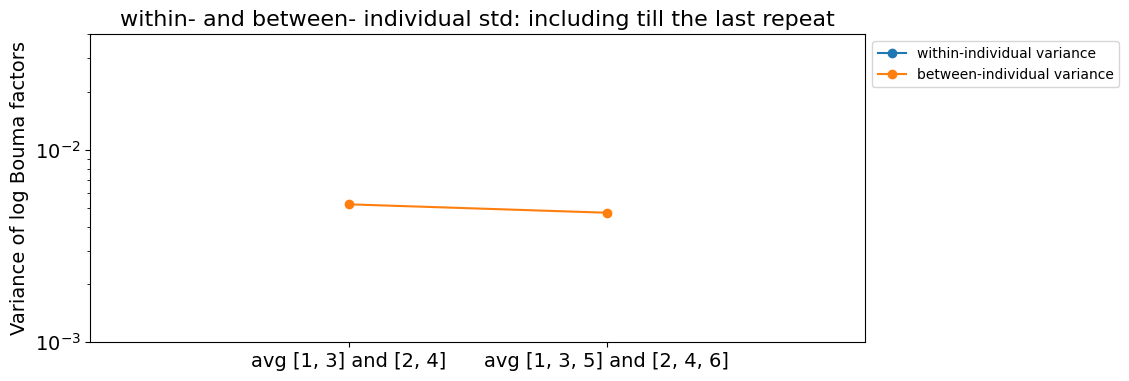

In [82]:
plt.figure(figsize=(10, 4))
plt.plot([1, 2], [within_4rep_testRetest, within_6rep_testRetest], marker='o', label='within-individual variance')
plt.plot([1, 2], [btw_4rep_testRetest, btw_6rep_testRetest], marker='o', label='between-individual variance')

plt.title('within- and between- individual std: including till the last repeat', fontsize = 16)
string_labels = ['avg [1, 3] and [2, 4]', 'avg [1, 3, 5] and [2, 4, 6]']
plt.xticks(ticks=[1, 2], labels=string_labels)
plt.xlim([0, 3])
plt.ylim([0.001, 0.04])
plt.ylabel('Variance of log Bouma factors', fontsize = 14)
plt.yscale('log')
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().tick_params(labelsize=14)
plt.show()

In [83]:
subj_testRetest_log = average_repeats(subj_avgRL_log, [[1,2],[3,4]])
within_4rep, btw_4rep = calculate_within_btw_std(subj_testRetest_log)
print(f'4 repeats, test-retest \n Within: {within_4rep}\n Between: {btw_4rep}')

subj_testRetest_log = average_repeats(subj_avgRL_log, [[1,2,3],[4,5,6]])
within_6rep, btw_6rep = calculate_within_btw_std(subj_testRetest_log)
print(f'6 repeats, test-retest \n Within: {within_6rep}\n Between: {btw_6rep}')

4 repeats, test-retest 
 Within: 0.0010313438475069384
 Between: 0.00521927863467206
6 repeats, test-retest 
 Within: 0.0005872432762301825
 Between: 0.004725936860196791


## Plot test-retest scatter plots

In [86]:
def plot_test_retest_scatter(data, group_X, group_Y):
    '''
    This function filters the data given the provided groupings and plots a scatter plot of test vs. retest
    It can give us an intuition of the within- and between- individual variances
    (i.e., if the within-std is large relative to the btw-std, R is low, and vice versa)
    
    Inputs:
    subj_data:        thresholds for each repeat of each individual. 
                      2D matrix with rows as individuals and columns as repeats.
    group_X, group_Y: specify which repeat(s) (i.e., columns) to include when averaging and plotting
                      for each dimension (X and Y).
                      These two arrays are lists but not np arrays.
    '''
    
    # filter data given the provided groupings
    group_X_array = np.array(group_X)
    group_Y_array = np.array(group_Y)

    data_X = data[:, group_X_array - 1]
    data_Y = data[:, group_Y_array - 1]
    
    
    # calculate one mean for each subject
    means_X = np.nanmean(data_X, axis = 1)
    means_Y = np.nanmean(data_Y, axis = 1)
    
    r_value, _ = pearsonr(means_X, means_Y)
    

    # Create scatter plot
    plt.figure(figsize=(4, 4))  # Make the plot square
    plt.scatter(10 ** means_X, 10 ** means_Y, color='purple', alpha = 0.7)
    plt.plot([0.1, 1.1], [0.1, 1.1], color='red', linestyle='--', label='y = x')  # Line y = x

    # Set axes to have equal scale
    plt.axis('equal')
    plt.xscale('log')
    plt.yscale('log')

    # add ticks and format them as normal floats
    tick_positions = np.linspace(0.1, 1, num=4)  
    plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions], fontsize = 12)
    plt.yticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions], fontsize = 12)

    # Add labels and legend
    plt.xlabel(f'Average over repeats {group_X}', fontsize = 14)
    plt.ylabel(f'Average over repeats {group_Y}', fontsize = 14)
    plt.title(f'Test vs. Retest Correlation (R = {round(r_value,2)})', fontsize = 16)

    # Show the plot
    plt.show()


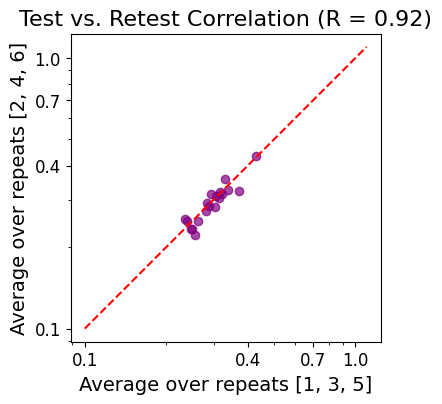

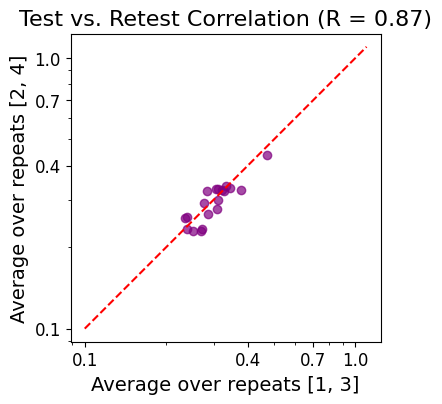

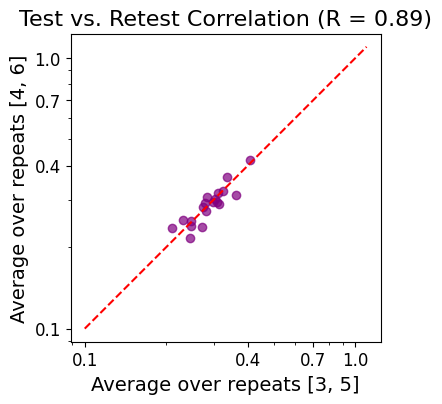

In [92]:
plot_test_retest_scatter(subj_avgRL_log, [1,3,5], [2,4,6])
plot_test_retest_scatter(subj_avgRL_log, [1,3], [2,4])
plot_test_retest_scatter(subj_avgRL_log, [3,5], [4,6])

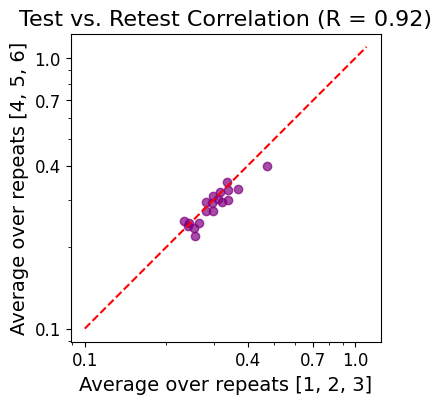

In [88]:
# learning
plot_test_retest_scatter(subj_avgRL_log, [1,2,3], [4,5,6])

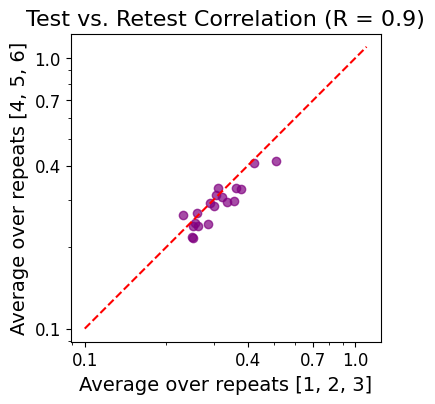

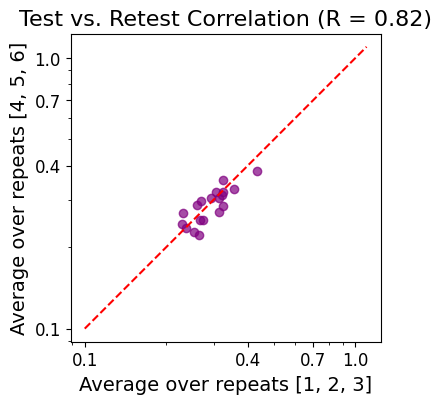

In [91]:
# right bouma factors are more variable than left bouma factors
plot_test_retest_scatter(np.log10(subj_right_thresholds), [1,2,3], [4,5,6])
plot_test_retest_scatter(np.log10(subj_left_thresholds), [1,2,3], [4,5,6])